**Poisson equation in 1D with Dirichlet/Periodic boundary conditions**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichletperiodic.html)

In [1]:
pip install deepxde

**Problem setup**

We will solve a Possion equation:

\begin{align}
        -\Delta u = \pi ^2 \text{sin} (\pi x), x \in [-1, 1],
    \end{align}

with the Periodic boundary conditions on the right boundary

\begin{align}
        u(0) = u(1)
    \end{align}

and the Dirichlet boundary conditions

\begin{align}
        u(-1) = 0.
    \end{align}

The exact solution is $u(x) = \text{sin} (\pi x)$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step.

First, the DeepXDE and TensorFlow (`tf`) modules are imported:

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Possion equation:

In [4]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

The first argument to `pde` is the network input, i.e., the $x$-coordinaate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Periodic boundary condition and the Dirichlet boundary condition respectively.

The location of the Periodic boundary condition is defined by a simple Python function. The function should return `True` for those points satisfying $x = 1$ and `False` otherwise (Note that because of rounding-off error, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent). In this function, the argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. Then a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the boundary of the geometry, in this case Periodic boundary when it reaches the right endpoint of the interval, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [5]:
def boundary_r(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 1)

The location of the Dirichlet boundary condition is defined in a similar way that the function should return `True` for those points satisfying $x = -1$ and `False` otherwise. The arguments in this function are similar to `boundary_r`, and the only difference is that in this case Dirichlet boundary condition is used when it reaches the left endpoint of the interval.

In [6]:
def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], -1)

Next, we define a function to return the value of $u(x)$ for the points $x$ on the Dirichlet boundary. In this case, it is $u(x) = 0$. For example, $sin(\pi * x)$ is 0 on the boundary, and thus we can also use

In [7]:
def func(x):
  return np.sin(np.pi * x)

Then, the Dirichlet boundary condition is defined as

In [8]:
bc1 = dde.icbc.DirichletBC(geom, func, boundary_l)

and the Periodic boundary condition is

In [9]:
bc2 = dde.icbc.PeriodicBC(geom, 0, boundary_r)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [10]:
data = dde.data.PDE(geom, pde, [bc1, bc2], 16, 2, solution=func, num_test=100)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e, 3 hidden layers) and width 50:

In [11]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [12]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.107915 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.888656 s



We also compute the $L^2$ relative error as a metric during training.

We then train the model for 10000 iterations:

In [13]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.30e+01, 6.44e-02, 2.57e-01]    [4.86e+01, 6.44e-02, 2.57e-01]    [8.44e-01]    
1000      [5.81e-04, 5.88e-10, 7.18e-08]    [6.10e-04, 5.88e-10, 7.18e-08]    [4.22e-04]    
2000      [4.86e-05, 1.81e-12, 1.43e-09]    [1.12e-04, 1.81e-12, 1.43e-09]    [1.22e-04]    
3000      [9.65e-04, 1.95e-04, 6.95e-04]    [5.61e-04, 1.95e-04, 6.95e-04]    [1.22e-02]    
4000      [9.03e-05, 1.67e-05, 5.69e-05]    [1.21e-04, 1.67e-05, 5.69e-05]    [3.41e-03]    
5000      [1.96e-05, 9.05e-07, 1.26e-06]    [4.62e-05, 9.05e-07, 1.26e-06]    [7.45e-04]    
6000      [7.49e-04, 1.33e-04, 6.24e-04]    [7.90e-04, 1.33e-04, 6.24e-04]    [1.28e-02]    
7000      [1.73e-05, 2.30e-06, 9.40e-06]    [4.17e-05, 2.30e-06, 9.40e-06]    [1.43e-03]    
8000      [2.16e-04, 4.77e-05, 1.59e-04]    [1.25e-04, 4.77e-05, 1.59e-04]    [5.81e-03]    
9000      [7.03e-04, 1.41e-04, 5.06e-04]    [5.71e-

**Additional Visualisation**

Additional code to give visualisation of the results. Taken parts are from **Complete code** section.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


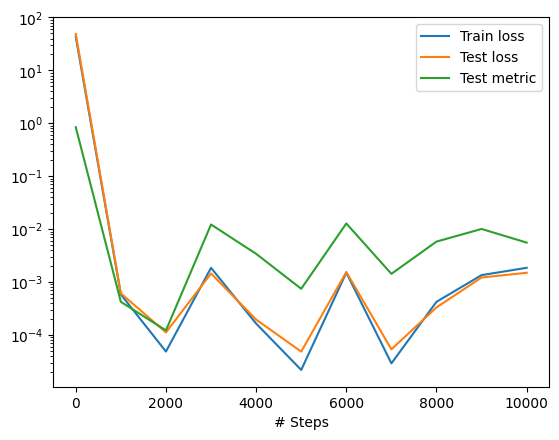

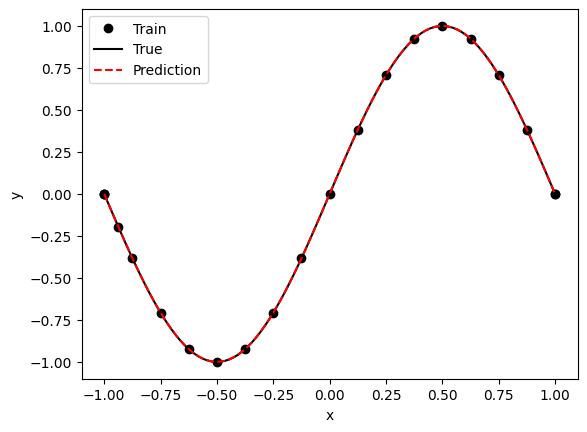

In [14]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [15]:
import matplotlib.pyplot as plt

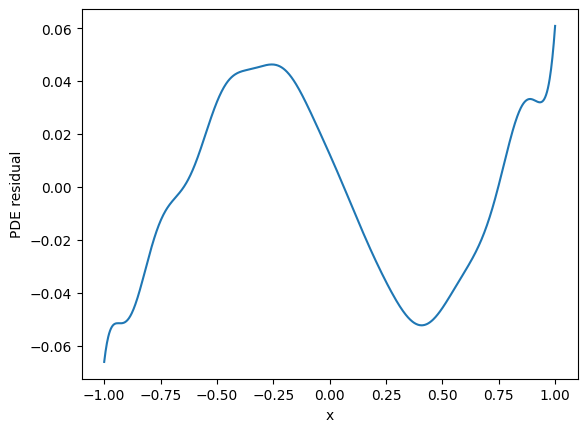

In [16]:
# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()